# Plot properties

In [83]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Visualizations 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# set the directory 
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/microterroir/Microbiome/Metadata')

# Management

In [95]:
df_management =pd.read_csv('Raw-MD_Vineyard_MV_data.csv')
df_management = df_management[['Plot', 'Year', 'Phenology_BudBreak', 'Phenology_Flowering',
       'Hail_Damage', 'Herbicide', 'Mildew', 'Grape_Yield_Estimate','Pruning_Weight']]
df_management['Plot'] = 'Plot' + df_management['Plot'].astype(str)

df_management.rename(columns={'Phenology_BudBreak':'BBCH 07: Bud Break', 'Phenology_Flowering' :'BBCH 65: Flowering',
                              'Grape_Yield_Estimate': 'Grape Yield Estimate', 'Pruning_Weight':'Pruning Weight', 
                              'Hail_Damage':'Hail Damage'}, inplace=True)

df_management.tail()

,Plot,Year,BBCH 07: Bud Break,BBCH 65: Flowering,Hail Damage,Herbicide,Mildew,Grape Yield Estimate,Pruning Weight
29,Plot14,2023,106,165,no,no,no,low,39.54
30,Plot15,2023,110,172,no,band,no,medium,38.91
31,Plot17,2023,103,164,no,band,no,medium,43.72
32,Plot19,2023,106,167,no,total,no,high,45.92
33,Plot20,2023,105,165,no,band,no,medium,37.67


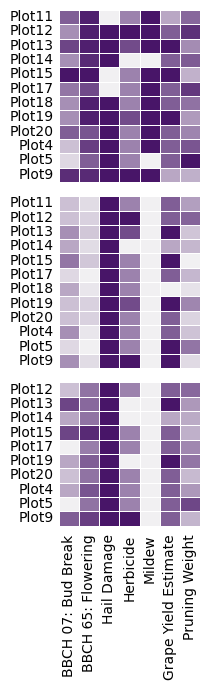

In [53]:
# Ensure categorical variables are properly ordered
df_management['Hail Damage'] = pd.Categorical(df_management['Hail Damage'], categories=['no', 'low', 'medium', 'high', 'total'], ordered=True)
df_management['Herbicide'] = pd.Categorical(df_management['Herbicide'], categories=['none', 'band', 'total', 'almost_total'], ordered=True)
df_management['Mildew'] = pd.Categorical(df_management['Mildew'], categories=['no', 'yes'], ordered=True)
df_management['Grape Yield Estimate'] = pd.Categorical(df_management['Grape Yield Estimate'], categories=['low', 'medium', 'high'], ordered=True)

# Convert categorical variables to numeric encoding
df_encoded = df_management.copy()
for col in ['Hail Damage', 'Herbicide', 'Mildew', 'Grape Yield Estimate']:
    df_encoded[col] = df_encoded[col].cat.codes  # Convert categories to numbers

# Define heatmap columns
heatmap_columns = ['BBCH 07: Bud Break', 'BBCH 65: Flowering', 'Hail Damage', 'Herbicide', 
                   'Mildew', 'Grape Yield Estimate', 'Pruning Weight']

# Sort by Year and Plot
df_encoded = df_encoded.sort_values(['Year', 'Plot']).set_index(['Year', 'Plot'])

# Create an empty row (NaN) to visually separate years
empty_row = pd.DataFrame(np.nan, index=pd.MultiIndex.from_tuples([('', '')], names=['Year', 'Plot']), columns=heatmap_columns)

# Rebuild the dataframe with empty rows between years
dfs = []
for year in df_encoded.index.get_level_values('Year').unique():
    dfs.append(df_encoded.loc[year])  # Keep multi-index structure
    dfs.append(empty_row)  # Add empty row as separator

df_with_spaces = pd.concat(dfs)

# Remove labels for empty rows
df_with_spaces.index = df_with_spaces.index.map(lambda x: '' if x[0] == '' else x)

# Normalize each column separately
for col in heatmap_columns:
    min_val = df_with_spaces[col].min(skipna=True)
    max_val = df_with_spaces[col].max(skipna=True)
    if min_val != max_val:  # Avoid division by zero
        df_with_spaces[col] = (df_with_spaces[col] - min_val) / (max_val - min_val)

# Custom colormap from white to #481568FF
custom_palette = sns.light_palette("#481568FF", as_cmap=True)

# Plot heatmap
plt.figure(figsize=(2.2, 7))
ax = sns.heatmap(df_with_spaces, cmap=custom_palette, annot=False, fmt='.1f', linewidths=0.5, 
                 mask=df_with_spaces.isna(),  # Hide empty rows
                 xticklabels=True, yticklabels=True, cbar=False, cbar_kws={'shrink': 0.4})  # Shrink colorbar

# Formatting
#plt.title("Management Properties by Plot and Year")
plt.ylabel("")
plt.xticks(rotation=90, ha="center")
plt.yticks(rotation=0)

ax.tick_params(axis='both', length=0)
ax.xaxis.set_tick_params(pad=-4) 

plt.tight_layout()
plt.savefig("/Users/lfloerl/Desktop/MICROTERROIR/Figures/Management_Heatmap_Combined.png", dpi=1200)
plt.show()


# Other properties

In [62]:
df_chem = pd.read_csv('RawMD-Soil_properties.csv')
df_chem = df_chem.loc[:, ~df_chem.columns.str.startswith("Unnamed")]

In [ ]:
df_plots = pd.read_csv('RawMD-Lavaux_plots.csv')
df_plots['Plot'] = 'Plot_' + df_plots['Plot'].astype(str)

In [87]:
df_plots_merged = df_plots.merge(df_chem, on='Plot')
df_plots_merged.set_index('Plot', inplace=True)
df_plots_merged_plot = df_plots_merged[['Altitude', 'Average_slope', 'Exposition', 'Average_radiation', 'Soil_thickness', 
                   'Soil_type', 'Soil_depth', 'Hydromorphie', 'Geology', 'Gravel_Percentage', 
                   'Organic_Matter',  'Clay_Percentage', 'Silt_Percentage', 
                   'Sand_Percentage', 'N_total', 'CN_ratio']]
df_plots_merged_plot.columns = df_plots_merged_plot.columns.str.replace('_', ' ')
df_plots_merged_plot.head()

,Altitude,Average slope,Exposition,Average radiation,Soil thickness,Soil type,Soil depth,Hydromorphie,Geology,Gravel Percentage,Organic Matter,Clay Percentage,Silt Percentage,Sand Percentage,N total,CN ratio
Plot,,,,,,,,,,,,,,,,
Plot_4,450,30,South-West,937.5,calcosol,Calcaire,100-180,Slightly_redox,Molasse,>30%,1.9,32.9,41.1,26.0,0.13,8.3
Plot_5,400,30,South-West,912.5,calcosol,Calcaire,100-180,no_redox,Molasse,>30%,1.6,29.5,38.5,32.1,0.11,8.7
Plot_9,520,35,South-West,887.5,calcosol,Calcaire,100-180,no_redox,Molasse,>30%,1.7,22.9,42.4,34.7,0.11,9.5
Plot_12,520,15,South-West,937.5,colluviosol,Calcique,above_150,Slightly_redox,Colluvium,>30%,3.1,34.0,41.3,24.7,0.18,10.0
Plot_13,580,30,South-West,937.5,calcosol,Calcaire,100-180,Slightly_redox,Molasse,>30%,1.7,37.1,38.8,24.2,0.12,8.5


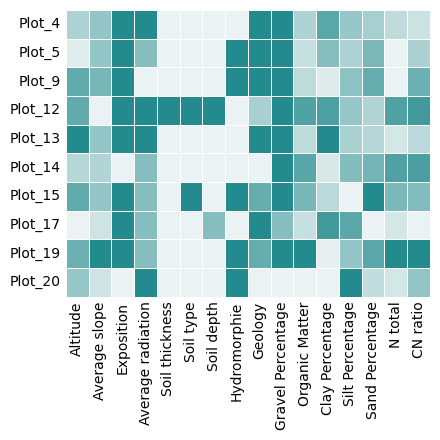

In [94]:
# Step 1: Encode categorical columns (non-numeric)
label_encoder = LabelEncoder()

categorical_columns = ['Exposition', 'Soil type', 'Soil thickness', 'Soil depth', 'Hydromorphie', 'Geology', 'Gravel Percentage']
for col in categorical_columns:
    df_plots_merged_plot.loc[:, col] = label_encoder.fit_transform(df_plots_merged_plot[col])

# Step 2: Normalize each column separately
for col in df_plots_merged_plot.columns:
    if df_plots_merged_plot[col].dtype in ['float64', 'int64']:  # Only normalize numeric columns
        min_val = df_plots_merged_plot[col].min(skipna=True)
        max_val = df_plots_merged_plot[col].max(skipna=True)
        if min_val != max_val:  # Avoid division by zero
            df_plots_merged_plot.loc[:, col] = (df_plots_merged_plot[col] - min_val) / (max_val - min_val)

# Step 3: Create custom colormap
custom_palette = sns.light_palette("#238A8DFF", as_cmap=True)

# Step 4: Plot heatmap
plt.figure(figsize=(4.5, 4.5))
ax = sns.heatmap(df_plots_merged_plot, cmap=custom_palette, annot=False, fmt='.1f', linewidths=0.5, 
                 mask=df_plots_merged_plot.isna(),  # Hide empty rows
                 xticklabels=True, yticklabels=True, cbar=False, cbar_kws={'shrink': 0.4})  # Shrink colorbar

# Formatting
plt.ylabel("")
plt.xticks(rotation=90, ha="center")
plt.yticks(rotation=0)

ax.tick_params(axis='both', length=0)

plt.tight_layout()
plt.savefig("/Users/lfloerl/Desktop/MICROTERROIR/Figures/PlotProperites_Heatmap.png", dpi=1200)
plt.show()
